In [1]:
# All comments in English
import sys, os, pathlib
print("PY:", sys.executable)  # deve ser .../projects/slicing/venv/bin/python
print("CWD:", os.getcwd())
print("Has utils here?:", (pathlib.Path.cwd()/"utils").exists())


PY: /home/ceciluz/projects/slicing/venv/bin/python
CWD: /home/ceciluz/projects/slicing/simulator
Has utils here?: True


In [6]:
from utils.create_folder import create_simulation_folder

In [7]:
results_dir = create_simulation_folder()


[INFO] Simulation folder created: results/2025-11-12_09-14-02


# Corridor restrictions

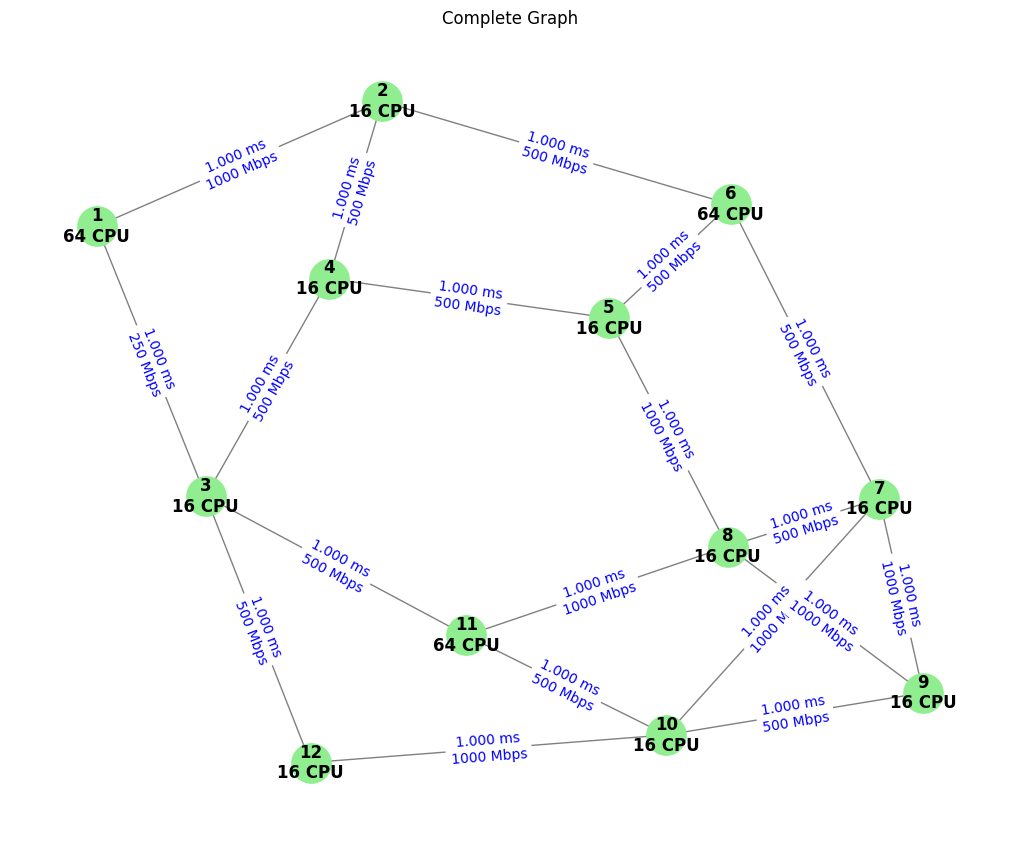

In [9]:
from utils.topology import topology_bayern, draw_graph, topologie_finlande, topology_brazil
from utils.generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()

draw_graph(G)


In [10]:

from utils.generate_slices import generate_random_slices


# === Define corridor in the topology ===
vnf_profiles = [
    {"cpu": 2, "throughput": 40, "latency": 120},
    {"cpu": 4, "throughput": 50, "latency": 180},
    {"cpu": 6, "throughput": 60, "latency": 200},
    {"cpu": 8, "throughput": 75, "latency": 250}
]
# === Generate slices ===
slices = generate_random_slices(G, vnf_profiles, num_slices=6, num_vnfs_per_slice=3, entry = 6)
slices

[([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf0_0', 'slice': 0},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf0_1', 'slice': 0},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf0_2', 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 40, 'latency': 120},
   {'from': 'vnf0_1', 'to': 'vnf0_2', 'bandwidth': 50, 'latency': 180}],
  6),
 ([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf1_0', 'slice': 1},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf1_1', 'slice': 1},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf1_2', 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 40, 'latency': 120},
   {'from': 'vnf1_1', 'to': 'vnf1_2', 'bandwidth': 50, 'latency': 180}],
  6),
 ([{'cpu': 2, 'throughput': 40, 'latency': 120, 'id': 'vnf2_0', 'slice': 2},
   {'cpu': 4, 'throughput': 50, 'latency': 180, 'id': 'vnf2_1', 'slice': 2},
   {'cpu': 6, 'throughput': 60, 'latency': 200, 'id': 'vnf2_2', 'slice': 2}],
  

In [11]:
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}

link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})

link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})


In [12]:
# === Run heuristics inside the corridor ===
from heuristics.a_star import run_astar
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.a_star_energy_aware import energy_aware_astar

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_energy_aware_a_star, results_energy_aware_a_star = energy_aware_astar(
    G=G,
    slices=slices,
    node_capacity_base=node_capacity_base,
    link_capacity_base=link_capacity_base,
    w_nodes=1.0, w_links=1.0
   )

# === Display results ===
display(df_astar)
display(df_ff)
display(df_abo)
display(df_fabo)
display(df_bestfit)
display(df_energy_aware_a_star)


[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][ABO] === Solving slice 1 (3 VNFs, 2 VLs) ===
[INFO][ABO] Found feasible solution after 44 states.
[SUMMARY][ABO] Slice 1 accepted. min_node_cpu=10, links_low_bw=0

[INFO][ABO] === Solving slice 2 (3 V

,slice,accepted,g_cost
0,1,True,2.0
1,2,True,2.0
2,3,True,2.0
3,4,True,2.0
4,5,True,2.0
5,6,True,2.0


,slice,accepted,g_cost
0,1,True,5.0
1,2,True,5.0
2,3,True,4.0
3,4,True,4.0
4,5,True,5.0
5,6,True,5.0


,slice,accepted,g_cost
0,1,True,3.0
1,2,True,3.0
2,3,True,3.0
3,4,True,3.0
4,5,True,3.0
5,6,True,3.0


,slice,accepted,g_cost
0,1,True,3.0
1,2,True,3.0
2,3,True,3.0
3,4,True,3.0
4,5,True,3.0
5,6,True,3.0


,slice,accepted,g_cost
0,1,True,4.0
1,2,True,5.0
2,3,True,4.0
3,4,True,5.0
4,5,True,4.0
5,6,True,5.0


,slice,accepted,nodes_used,links_used,energy
0,1,True,3,2,0.43
1,2,True,3,2,0.43
2,3,True,3,2,0.43
3,4,True,3,2,0.43
4,5,True,3,2,0.43
5,6,True,3,2,0.43


In [13]:
from utils.generate_graphs import plot_all_routes

In [14]:
pos = {
    n: (data["Longitude"], data["Latitude"])
    for n, data in G.nodes(data=True)
    if "Longitude" in data and "Latitude" in data
}

In [15]:
plot_all_routes(
    G,
    results_astar,
    title="All A* Routed Paths (All Slices)",
    results_dir=results_dir
)


/home/ceciluz/projects/slicing/simulator/utils/generate_graphs.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Saved route plot to results/2025-11-12_09-14-02/all_a*_routed_paths_(all_slices).png


In [16]:
plot_all_routes(G, bestfit_results, title="All best fit Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-11-12_09-14-02/all_best_fit_routed_paths_(all_slices).png


In [17]:
plot_all_routes(G, ff_results, title="All first fit Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-11-12_09-14-02/all_first_fit_routed_paths_(all_slices).png


In [18]:
plot_all_routes(G, abo_results, title="All ABO Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-11-12_09-14-02/all_abo_routed_paths_(all_slices).png


In [19]:
plot_all_routes(G, fabo_results, title="All FABO Routed Paths (All Slices)",
    results_dir=results_dir)

[INFO] Saved route plot to results/2025-11-12_09-14-02/all_fabo_routed_paths_(all_slices).png


In [20]:
plot_all_routes(
    G,
    results_energy_aware_a_star,
    title="All Energy Aware A*  Routed Paths (All Slices)",
    results_dir=results_dir
)

[INFO] Saved route plot to results/2025-11-12_09-14-02/all_energy_aware_a*__routed_paths_(all_slices).png


[MILP] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2720135
Academic license 2720135 - for non-commercial use only - registered to ce___@imt-atlantique.fr
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 3000
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  3000
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Ac

/home/ceciluz/projects/slicing/simulator/utils/generate_graphs.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


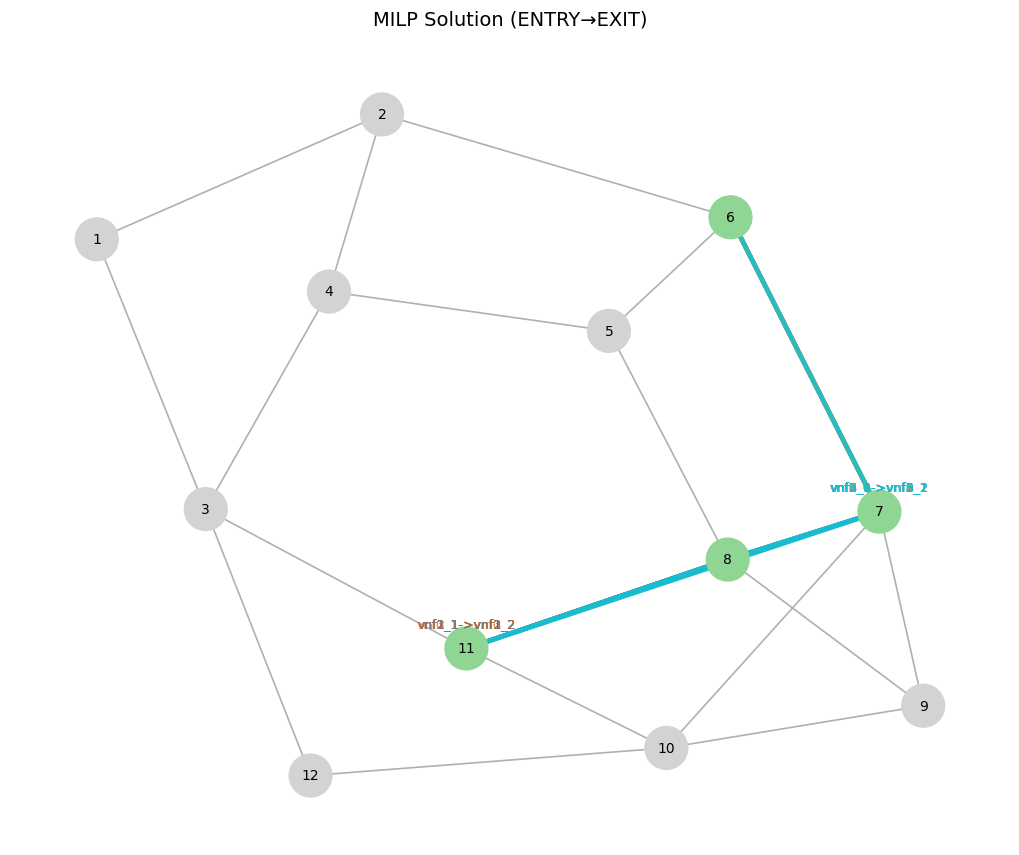

In [21]:
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi
from milp.create_instance import create_instance
from utils.generate_graphs import plot_solution_heuristic

# === 1. Criar instance ===
instance = create_instance(G, slices)
instance.entry_node = 6

# === 2. Rodar o MILP ===
milp_res = solve_gurobi(instance, msg=True, time_limit=3000)
# === 3. Adaptar e visualizar ===
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)
print(milp_adapter) 

plot_solution_heuristic(G, milp_adapter, title="MILP Solution (ENTRY→EXIT)")


In [16]:
import gurobipy as gp
m = gp.Model()
print("✅ Gurobi kernel is ready!")

✅ Gurobi kernel is ready!


In [22]:
# === Run MILP ===
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

instance = create_instance(G, slices)
milp_res = solve_gurobi(instance, msg=True, time_limit=120)
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)

# === Add all methods to comparison dict ===
method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "A* Energy Aware": results_energy_aware_a_star,
    "First Fit": ff_results,
    "Best Fit": bestfit_results,
    "MILP (Gurobi)": [milp_adapter],   # ⚠️ important: wrap in list
}


[MILP] Edge pruning: |E_full|=19 → |E_use|=19
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter Presolve to value 2
Set parameter Cuts to value 3
Set parameter NumericFocus to value 1
Set parameter IntFeasTol to value 1e-05
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  120
MIPGap  0.05
Heuristics  0.5
MIPFocus  1
Cuts  3
NumericFocus  1
Presolve  2

Academic license 2720135 - for non-commercial use only - registered to ce___@imt-atlantique.fr
Optimize a model with 417 rows, 620 columns and 3027 nonzeros (Min)
Model fingerprint: 0x37efbe

In [24]:
from utils.metrics import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_energy_new,
    compute_milp_bandwidth_latency,
    count_accepted_slices
)

comparison_rows = []

for method_name, result_list in method_results.items():
    if not result_list:
        continue

    # --- Energy metrics ---
    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, _ = compute_energy_per_node(result_list, slices, node_capacity_base)
    normalized_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)

    # --- Bandwidth & Latency ---
    if "MILP" in method_name and len(result_list) == 1:
        
        total_bw, total_lat, _, _ = compute_milp_bandwidth_latency(milp_res, instance)
    else:
        total_bw_list = compute_total_bandwidth(result_list, slices)
        total_lat_list = compute_total_latency(result_list, link_latency)
        total_bw = sum(b for b in total_bw_list if b is not None)
        total_lat = sum(l for l in total_lat_list if l is not None)

    # --- Build comparison row ---
    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": count_accepted_slices(result_list, slices, verbose=False),
        "Total Bandwidth": total_bw,
        "Total Latency": total_lat,
        "Total Energy": normalized_energy
    })

# --- Final DataFrame ---
df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)


,Method,Slices Accepted,Total Bandwidth,Total Latency,Total Energy
0,A*,6,540.0,12.0,19.3050
1,ABO,6,540.0,18.0,17.0175
2,FABO,6,540.0,18.0,18.0175
3,A* Energy Aware,6,540.0,12.0,19.3050
4,First Fit,6,730.0,28.0,16.3775
5,Best Fit,6,810.0,27.0,24.3000
6,MILP (Gurobi),6,800.0,18.0,10.5500


In [19]:
df_milp = pd.DataFrame([
    {
        "slice": len(slices),      # número total de slices
        "accepted": True if milp_adapter else False,
        "g_cost": milp_res.objective if milp_res.objective else None
    }
])


In [20]:
from datetime import datetime

num_slices = len(slices)
num_vnfs_total = sum(len(v[0]) for v in slices)

summary_info = {
    "timestamp": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    "num_slices": [num_slices],
    "num_vnfs_total": [num_vnfs_total]
}

import pandas as pd
df_info = pd.DataFrame(summary_info)
df_info.to_csv(f"{results_dir}/experiment_info.csv", index=False)
df_astar.to_csv(f"{results_dir}/astar_results.csv", index=False)
df_energy_aware_a_star.to_csv(f"{results_dir}/energy_aware_a_star.csv", index=False)
df_abo.to_csv(f"{results_dir}/abo_results.csv", index=False)
df_fabo.to_csv(f"{results_dir}/fabo_results.csv", index=False)
df_bestfit.to_csv(f"{results_dir}/bestfit_results.csv", index=False)
df_ff.to_csv(f"{results_dir}/ff_results.csv", index=False)
df_milp.to_csv(f"{results_dir}/milp_results.csv", index=False)
df_metrics.to_csv(f"{results_dir}/metrics.csv", index=False)


In [21]:
with open(f"{results_dir}/log.txt", "w") as f:
    f.write(f"Experiment timestamp: {datetime.now()}\n")
    f.write(f"Number of slices: {num_slices}\n")
    f.write(f"Number of VNFs: {num_vnfs_total}\n")
    f.write("\n=== Summary ===\n")
    f.write(df_astar.to_string(index=False))
    f.write(df_abo.to_string(index=False))
    f.write(df_fabo.to_string(index=False))
    f.write(df_energy_aware_a_star.to_string(index=False))
    f.write(df_bestfit.to_string(index=False))
    f.write(df_ff.to_string(index=False))
    f.write(df_metrics.to_string(index=False))
    f.write("\n\n=== MILP ===\n")
    f.write(df_milp.to_string(index=False))

In [22]:
from utils.generate_graphs import plot_cpu_usage
plot_cpu_usage(G, slices, method_results, results_dir)


[INFO] Saved CPU utilization chart to results/2025-11-12_08-23-42/cpu_utilization.png


In [23]:
from milp.helpers import sanity_check_milp_gurobi
sanity_check_milp_gurobi(milp_res, instance, slices)

=== Sanity check MILP (Gurobi) ===
Objective value: 10.550
Status: 2

Node CPU usage:
  Node 1: used 0.00 / cap 64.00 
  Node 2: used 0.00 / cap 16.00 
  Node 3: used 0.00 / cap 16.00 
  Node 4: used 0.00 / cap 16.00 
  Node 5: used 0.00 / cap 16.00 
  Node 6: used 12.00 / cap 64.00 
  Node 7: used 8.00 / cap 16.00 
  Node 8: used 16.00 / cap 16.00 
  Node 9: used 0.00 / cap 16.00 
  Node 10: used 0.00 / cap 16.00 
  Node 11: used 36.00 / cap 64.00 
  Node 12: used 0.00 / cap 16.00 

[Slice 0]
  VNF vnf0_0 → Node(s) [6]
  VNF vnf0_1 → Node(s) [8]
  VNF vnf0_2 → Node(s) [11]
  VL (vnf0_0->vnf0_1) ✓ routed via [(6, 7), (7, 8)]
  VL (vnf0_1->vnf0_2) ✓ routed via [(8, 11)]
  → Slice 0 ACCEPTED ✓

[Slice 1]
  VNF vnf1_0 → Node(s) [6]
  VNF vnf1_1 → Node(s) [8]
  VNF vnf1_2 → Node(s) [11]
  VL (vnf1_0->vnf1_1) ✓ routed via [(6, 7), (7, 8)]
  VL (vnf1_1->vnf1_2) ✓ routed via [(8, 11)]
  → Slice 1 ACCEPTED ✓

[Slice 2]
  VNF vnf2_0 → Node(s) [6]
  VNF vnf2_1 → Node(s) [8]
  VNF vnf2_2 → Node(s

# Load and scalability 

In [27]:
# === Load & Scalability Experiment ===
# All comments in English

import os, random, time
import numpy as np
import pandas as pd
from copy import deepcopy
from datetime import datetime

# --- Imports ---
from utils.topology import topology_brazil, topologie_finlande
from utils.generate_slices import generate_random_slices
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.a_star_energy_aware import energy_aware_astar
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit

from utils.metrics import (
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
    count_accepted_slices,
)

# --- Output directory ---
results_dir =results_dir
os.makedirs(results_dir, exist_ok=True)

# --- Topology ---
G = topologie_finlande()
ENTRY = 6

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid ---
param_grid = {
    "num_slices": [4,6, 8, 10 ,12, 18, 20],
    "num_vnfs_per_slice": [2, 3],
    "seed": [1],
}

records = []

for num_slices in param_grid["num_slices"]:
    for num_vnfs in param_grid["num_vnfs_per_slice"]:
        for seed in param_grid["seed"]:
            random.seed(seed)
            np.random.seed(seed)

            print(f"\n[INFO] === Running Load Test: {num_slices} slices, {num_vnfs} VNFs, seed={seed} ===")

            # --- Generate slices ---
            slices = generate_random_slices(
                    G,
                    vnf_profiles,
                    num_slices=num_slices,
                    num_vnfs_per_slice=num_vnfs,
                    entry=ENTRY
                )


            # --- Run heuristics ---
            method_results = {}
            method_times = {}

            for name, func, args in [
                ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("Energy-Aware A*", energy_aware_astar,
 (G, slices, node_capacity_base, link_capacity_base,
  0.6, 0.4))


            ]:
                start = time.time()
                try:
                    df_res, res_list = func(*args)
                    method_results[name] = res_list
                except Exception as e:
                    print(f"[ERROR] {name} failed: {e}")
                    method_results[name] = []
                method_times[name] = time.time() - start

            # --- Compute metrics ---
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })



[INFO] === Running Load Test: 4 slices, 2 VNFs, seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][ABO] === Solving slice 1 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 1 accepted. min_node_cpu=14, links_low_bw=0

[INFO][ABO] === Solving slice 2 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 2 accepted. min_node_cpu=12, links_low_bw=0

[INFO][ABO] === Solving slice 3 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found fea

In [28]:

# --- Save & preview ---
df_load = pd.DataFrame(records)
output_path = os.path.join(results_dir, "load_scalability_results.csv")
df_load.to_csv(output_path, index=False)
print(f"\n[INFO] Results saved to {output_path}")
display(df_load)



[INFO] Results saved to results/2025-11-12_09-14-02/load_scalability_results.csv


,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec
0,2025-11-12 09:27:05,4,2,1,A*,4,8.4450,160.0,4.0,0.013831
1,2025-11-12 09:27:05,4,2,1,ABO,4,3.9100,160.0,8.0,1.674380
2,2025-11-12 09:27:05,4,2,1,FABO,4,10.1775,160.0,8.0,1.680624
3,2025-11-12 09:27:05,4,2,1,Best Fit,4,8.3000,320.0,16.0,0.001064
4,2025-11-12 09:27:05,4,2,1,First Fit,4,4.2850,160.0,12.0,0.000949
...,...,...,...,...,...,...,...,...,...,...
79,2025-11-12 09:31:30,20,3,1,ABO,20,54.5700,2630.0,95.0,19.500365
80,2025-11-12 09:31:30,20,3,1,FABO,20,56.5700,2600.0,92.0,19.004182
81,2025-11-12 09:31:30,20,3,1,Best Fit,20,51.2400,3160.0,106.0,0.006780
82,2025-11-12 09:31:30,20,3,1,First Fit,20,47.0675,3270.0,97.0,0.007621


In [30]:
# --- Load results CSV produced by your experiment generator ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Adjust this path to your saved file
csv_path = output_path
df = pd.read_csv(csv_path)

# Basic type coercion
num_cols = [
    "num_slices","num_vnfs_per_slice","seed","accepted",
    "total_energy","total_bandwidth","total_latency","runtime_sec"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Useful derived metrics
df["energy_per_accepted"]  = np.where(df["accepted"]>0, df["total_energy"]/df["accepted"], np.nan)
df["latency_per_accepted"] = np.where(df["accepted"]>0, df["total_latency"]/df["accepted"], np.nan)

df


,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,energy_per_accepted,latency_per_accepted
0,2025-11-12 09:27:05,4,2,1,A*,4,8.4450,160.0,4.0,0.013831,2.111250,1.00
1,2025-11-12 09:27:05,4,2,1,ABO,4,3.9100,160.0,8.0,1.674380,0.977500,2.00
2,2025-11-12 09:27:05,4,2,1,FABO,4,10.1775,160.0,8.0,1.680624,2.544375,2.00
3,2025-11-12 09:27:05,4,2,1,Best Fit,4,8.3000,320.0,16.0,0.001064,2.075000,4.00
4,2025-11-12 09:27:05,4,2,1,First Fit,4,4.2850,160.0,12.0,0.000949,1.071250,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...
79,2025-11-12 09:31:30,20,3,1,ABO,20,54.5700,2630.0,95.0,19.500365,2.728500,4.75
80,2025-11-12 09:31:30,20,3,1,FABO,20,56.5700,2600.0,92.0,19.004182,2.828500,4.60
81,2025-11-12 09:31:30,20,3,1,Best Fit,20,51.2400,3160.0,106.0,0.006780,2.562000,5.30
82,2025-11-12 09:31:30,20,3,1,First Fit,20,47.0675,3270.0,97.0,0.007621,2.353375,4.85


In [31]:
# --- Acceptance-aware utilities (STRICT and NORMALIZED views) ---

def _aggregate_scenario(d, aggregate_over_seeds=True):
    """Aggregate rows for a fixed (num_slices, num_vnfs_per_slice) scenario."""
    if aggregate_over_seeds:
        out = (d.groupby("method", as_index=False)
                 .agg(total_energy=("total_energy","mean"),
                      total_latency=("total_latency","mean"),
                      runtime_sec=("runtime_sec","mean"),
                      total_bandwidth=("total_bandwidth","mean"),
                      accepted=("accepted","mean"),
                      energy_per_accepted=("energy_per_accepted","mean"),
                      latency_per_accepted=("latency_per_accepted","mean")))
    else:
        # If you want to keep per-seed, you can drop this mean and handle outside
        out = d.copy()
    return out

def fair_percentages_for_scenario(df, slices_target, vnfs_target, baseline="A*", aggregate_over_seeds=True):
    """
    Build STRICT and NORMALIZED percentage comparisons for a single scenario (num_slices, num_vnfs_per_slice).
    STRICT: only methods that reached max acceptance (apple-to-apple).
    NORMALIZED: all methods with energy scaled to the same acceptance (max) -> conservative penalty.
    """
    d = df[(df["num_slices"]==slices_target) & (df["num_vnfs_per_slice"]==vnfs_target)].copy()
    if d.empty:
        raise ValueError("No rows for the requested scenario.")

    agg = _aggregate_scenario(d, aggregate_over_seeds=aggregate_over_seeds).copy()
    # Handle rounding noise on accepted when averaged across seeds
    agg["accepted_round"] = agg["accepted"].round(6)
    max_acc = agg["accepted_round"].max()

    # -------- STRICT (only max acceptance) --------
    strict = agg[agg["accepted_round"] == max_acc].copy()
    if not strict.empty:
        worst_E = strict["total_energy"].max()
        worst_L = strict["total_latency"].max()
        worst_T = strict["runtime_sec"].max()

        strict["gain_energy_vs_worst_%"]  = (worst_E - strict["total_energy"]) / worst_E * 100.0
        strict["gain_latency_vs_worst_%"] = (worst_L - strict["total_latency"]) / worst_L * 100.0
        strict["gain_runtime_vs_worst_%"] = (worst_T - strict["runtime_sec"]) / worst_T * 100.0

        if baseline in strict["method"].values:
            b = strict.loc[strict["method"]==baseline].iloc[0]
            strict["gain_energy_vs_baseline_%"]  = (b["total_energy"]  - strict["total_energy"])  / b["total_energy"]  * 100.0
            strict["gain_latency_vs_baseline_%"] = (b["total_latency"] - strict["total_latency"]) / b["total_latency"] * 100.0
            strict["gain_runtime_vs_baseline_%"] = (b["runtime_sec"]   - strict["runtime_sec"])   / b["runtime_sec"]   * 100.0
        else:
            strict[["gain_energy_vs_baseline_%","gain_latency_vs_baseline_%","gain_runtime_vs_baseline_%"]] = np.nan

        strict = strict.sort_values("gain_energy_vs_worst_%", ascending=False).reset_index(drop=True)

    # -------- NORMALIZED (energy scaled to max acceptance) --------
    norm = agg.copy()
    norm["energy_norm_to_max_accept"] = np.where(
        norm["accepted_round"]>0,
        norm["total_energy"] * (max_acc / norm["accepted_round"]),
        np.inf
    )
    worst_E_norm = norm["energy_norm_to_max_accept"].replace([np.inf,-np.inf], np.nan).max()
    norm["gain_energy_norm_vs_worst_%"] = (worst_E_norm - norm["energy_norm_to_max_accept"]) / worst_E_norm * 100.0
    norm["acceptance_ratio_%"] = (norm["accepted_round"]/max_acc)*100.0
    norm["acceptance_gap"] = max_acc - norm["accepted_round"]
    norm = norm.sort_values("gain_energy_norm_vs_worst_%", ascending=False).reset_index(drop=True)

    return strict, norm, int(max_acc)

def plot_percent_bars(df_summary, col_percent, title):
    """One simple bar chart per percent metric (matplotlib only, no custom colors)."""
    x = np.arange(len(df_summary))
    y = df_summary[col_percent].values
    labels = df_summary["method"].values

    plt.figure(figsize=(8,4))
    plt.bar(x, y)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylabel("%")
    plt.title(title)
    plt.tight_layout()
    plt.show()


[Scenario] 12 slices, 3 VNFs/slice | Max accepted = 12

=== STRICT (only methods with max acceptance) ===


,method,accepted,total_energy,total_latency,runtime_sec,energy_per_accepted,latency_per_accepted,gain_energy_vs_worst_%,gain_latency_vs_worst_%,gain_runtime_vs_worst_%,gain_energy_vs_baseline_%,gain_latency_vs_baseline_%,gain_runtime_vs_baseline_%
0,A*,12.0,28.22875,25.0,0.189360,2.352396,2.083333,23.457836,59.677419,98.889340,0.000000,0.0,0.000000
1,Energy-Aware A*,12.0,28.28250,26.0,0.694319,2.356875,2.166667,23.312093,58.064516,95.927590,-0.190409,-4.0,-266.665617
2,First Fit,12.0,30.64625,62.0,0.003535,2.553854,5.166667,16.902793,0.000000,99.979267,-8.563964,-148.0,98.133296
3,ABO,12.0,35.22875,41.0,17.049329,2.935729,3.416667,4.477359,33.870968,0.000000,-24.797414,-64.0,-8903.652324
4,FABO,12.0,36.23500,42.0,15.054902,3.019583,3.500000,1.748915,32.258065,11.697981,-28.362042,-68.0,-7850.406807
5,Best Fit,12.0,36.88000,54.0,0.005130,3.073333,4.500000,0.000000,12.903226,99.969913,-30.646947,-116.0,97.291101



=== NORMALIZED (all methods scaled to same acceptance) ===


,method,accepted,acceptance_ratio_%,energy_per_accepted,energy_norm_to_max_accept,gain_energy_norm_vs_worst_%,total_latency,runtime_sec
0,A*,12.0,100.0,2.352396,28.22875,23.457836,25.0,0.189360
1,Energy-Aware A*,12.0,100.0,2.356875,28.28250,23.312093,26.0,0.694319
2,First Fit,12.0,100.0,2.553854,30.64625,16.902793,62.0,0.003535
3,ABO,12.0,100.0,2.935729,35.22875,4.477359,41.0,17.049329
4,FABO,12.0,100.0,3.019583,36.23500,1.748915,42.0,15.054902
5,Best Fit,12.0,100.0,3.073333,36.88000,0.000000,54.0,0.005130


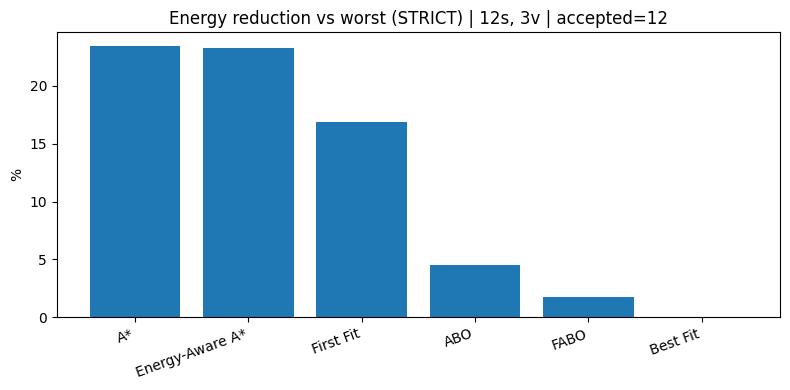

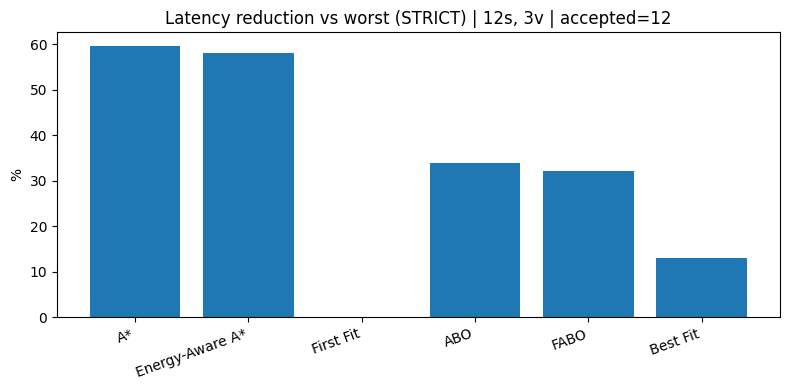

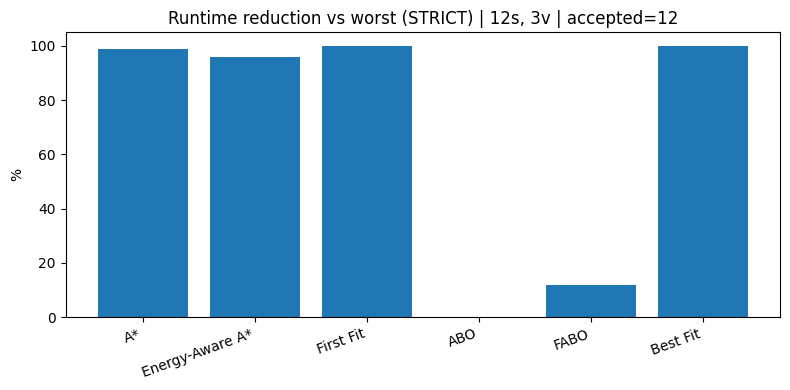

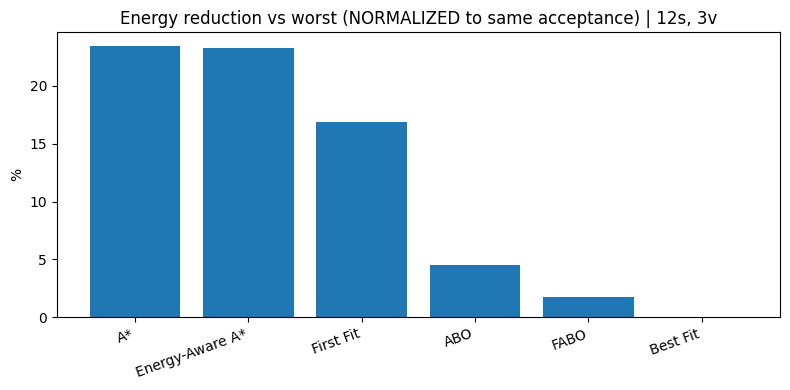

In [32]:
# --- Choose your scenario here ---
slices_target = 12
vnfs_target   = 3

strict_cmp, norm_cmp, max_acc = fair_percentages_for_scenario(
    df, slices_target, vnfs_target,
    baseline="A*", aggregate_over_seeds=True
)

print(f"[Scenario] {slices_target} slices, {vnfs_target} VNFs/slice | Max accepted = {max_acc}")

print("\n=== STRICT (only methods with max acceptance) ===")
display(strict_cmp[[
    "method","accepted","total_energy","total_latency","runtime_sec",
    "energy_per_accepted","latency_per_accepted",
    "gain_energy_vs_worst_%","gain_latency_vs_worst_%","gain_runtime_vs_worst_%",
    "gain_energy_vs_baseline_%","gain_latency_vs_baseline_%","gain_runtime_vs_baseline_%"
]])

print("\n=== NORMALIZED (all methods scaled to same acceptance) ===")
display(norm_cmp[[
    "method","accepted","acceptance_ratio_%","energy_per_accepted",
    "energy_norm_to_max_accept","gain_energy_norm_vs_worst_%",
    "total_latency","runtime_sec"
]])

# Quick plots
if not strict_cmp.empty:
    plot_percent_bars(strict_cmp, "gain_energy_vs_worst_%",
                      f"Energy reduction vs worst (STRICT) | {slices_target}s, {vnfs_target}v | accepted={max_acc}")
    plot_percent_bars(strict_cmp, "gain_latency_vs_worst_%",
                      f"Latency reduction vs worst (STRICT) | {slices_target}s, {vnfs_target}v | accepted={max_acc}")
    plot_percent_bars(strict_cmp, "gain_runtime_vs_worst_%",
                      f"Runtime reduction vs worst (STRICT) | {slices_target}s, {vnfs_target}v | accepted={max_acc}")

plot_percent_bars(norm_cmp, "gain_energy_norm_vs_worst_%",
                  f"Energy reduction vs worst (NORMALIZED to same acceptance) | {slices_target}s, {vnfs_target}v")


In [33]:
# --- Batch all scenarios: export STRICT and NORMALIZED summaries to CSVs ---

def batch_all_scenarios(df, baseline="A*", aggregate_over_seeds=True,
                        out_strict="summary_STRICT.csv", out_norm="summary_NORMALIZED.csv"):
    rows_strict, rows_norm = [], []
    for (slices_target, vnfs_target), d in df.groupby(["num_slices","num_vnfs_per_slice"]):
        try:
            strict_cmp, norm_cmp, max_acc = fair_percentages_for_scenario(
                df, slices_target, vnfs_target, baseline=baseline, aggregate_over_seeds=aggregate_over_seeds
            )
            if not strict_cmp.empty:
                sc = strict_cmp.copy()
                sc.insert(0, "num_vnfs_per_slice", vnfs_target)
                sc.insert(0, "num_slices", slices_target)
                sc.insert(2, "max_accepted_in_scenario", max_acc)
                rows_strict.append(sc)

            nc = norm_cmp.copy()
            nc.insert(0, "num_vnfs_per_slice", vnfs_target)
            nc.insert(0, "num_slices", slices_target)
            nc.insert(2, "max_accepted_in_scenario", max_acc)
            rows_norm.append(nc)
        except Exception as e:
            print(f"[WARN] Scenario ({slices_target}, {vnfs_target}) skipped: {e}")

    strict_all = pd.concat(rows_strict, ignore_index=True) if rows_strict else pd.DataFrame()
    norm_all   = pd.concat(rows_norm,   ignore_index=True) if rows_norm   else pd.DataFrame()

    if not strict_all.empty:
        strict_all.to_csv(out_strict, index=False)
        print(f"Saved STRICT summary to: {out_strict}")
    if not norm_all.empty:
        norm_all.to_csv(out_norm, index=False)
        print(f"Saved NORMALIZED summary to: {out_norm}")

    return strict_all, norm_all

strict_all, norm_all = batch_all_scenarios(
    df, baseline="A*", aggregate_over_seeds=True,
    out_strict="summary_preliminary_STRICT.csv",
    out_norm="summary_preliminary_NORMALIZED.csv"
)

display(strict_all.head(10))
display(norm_all.head(10))


Saved STRICT summary to: summary_preliminary_STRICT.csv
Saved NORMALIZED summary to: summary_preliminary_NORMALIZED.csv


,num_slices,num_vnfs_per_slice,max_accepted_in_scenario,method,total_energy,total_latency,runtime_sec,total_bandwidth,accepted,energy_per_accepted,latency_per_accepted,accepted_round,gain_energy_vs_worst_%,gain_latency_vs_worst_%,gain_runtime_vs_worst_%,gain_energy_vs_baseline_%,gain_latency_vs_baseline_%,gain_runtime_vs_baseline_%
0,4,2,4,ABO,3.9100,8.0,1.674380,160.0,4.0,0.977500,2.0,4.0,61.581921,50.000000,0.371568,53.700414,-100.0,-12005.869475
1,4,2,4,First Fit,4.2850,12.0,0.000949,160.0,4.0,1.071250,3.0,4.0,57.897323,25.000000,99.943538,49.259917,-200.0,93.139350
2,4,2,4,Best Fit,8.3000,16.0,0.001064,320.0,4.0,2.075000,4.0,4.0,18.447556,0.000000,99.936672,1.716992,-300.0,92.305040
3,4,2,4,A*,8.4450,4.0,0.013831,160.0,4.0,2.111250,1.0,4.0,17.022845,75.000000,99.177024,0.000000,0.0,0.000000
4,4,2,4,Energy-Aware A*,8.4450,4.0,0.041968,160.0,4.0,2.111250,1.0,4.0,17.022845,75.000000,97.502855,0.000000,0.0,-203.428601
5,4,2,4,FABO,10.1775,8.0,1.680624,160.0,4.0,2.544375,2.0,4.0,0.000000,50.000000,0.000000,-20.515098,-100.0,-12051.018755
6,4,3,4,First Fit,11.4850,18.0,0.001489,460.0,4.0,2.871250,4.5,4.0,26.765503,0.000000,99.979816,26.765503,-125.0,97.819787
7,4,3,4,Best Fit,13.2600,18.0,0.001738,540.0,4.0,3.315000,4.5,4.0,15.447154,0.000000,99.976437,15.447154,-125.0,97.454905
8,4,3,4,FABO,15.1575,12.0,7.375414,360.0,4.0,3.789375,3.0,4.0,3.347681,33.333333,0.000000,3.347681,-50.0,-10701.458480
9,4,3,4,ABO,15.3450,12.0,6.919864,360.0,4.0,3.836250,3.0,4.0,2.152080,33.333333,6.176598,2.152080,-50.0,-10034.295760


,num_slices,num_vnfs_per_slice,max_accepted_in_scenario,method,total_energy,total_latency,runtime_sec,total_bandwidth,accepted,energy_per_accepted,latency_per_accepted,accepted_round,energy_norm_to_max_accept,gain_energy_norm_vs_worst_%,acceptance_ratio_%,acceptance_gap
0,4,2,4,ABO,3.9100,8.0,1.674380,160.0,4.0,0.977500,2.0,4.0,3.9100,61.581921,100.0,0.0
1,4,2,4,First Fit,4.2850,12.0,0.000949,160.0,4.0,1.071250,3.0,4.0,4.2850,57.897323,100.0,0.0
2,4,2,4,Best Fit,8.3000,16.0,0.001064,320.0,4.0,2.075000,4.0,4.0,8.3000,18.447556,100.0,0.0
3,4,2,4,A*,8.4450,4.0,0.013831,160.0,4.0,2.111250,1.0,4.0,8.4450,17.022845,100.0,0.0
4,4,2,4,Energy-Aware A*,8.4450,4.0,0.041968,160.0,4.0,2.111250,1.0,4.0,8.4450,17.022845,100.0,0.0
5,4,2,4,FABO,10.1775,8.0,1.680624,160.0,4.0,2.544375,2.0,4.0,10.1775,0.000000,100.0,0.0
6,4,3,4,First Fit,11.4850,18.0,0.001489,460.0,4.0,2.871250,4.5,4.0,11.4850,26.765503,100.0,0.0
7,4,3,4,Best Fit,13.2600,18.0,0.001738,540.0,4.0,3.315000,4.5,4.0,13.2600,15.447154,100.0,0.0
8,4,3,4,FABO,15.1575,12.0,7.375414,360.0,4.0,3.789375,3.0,4.0,15.1575,3.347681,100.0,0.0
9,4,3,4,ABO,15.3450,12.0,6.919864,360.0,4.0,3.836250,3.0,4.0,15.3450,2.152080,100.0,0.0


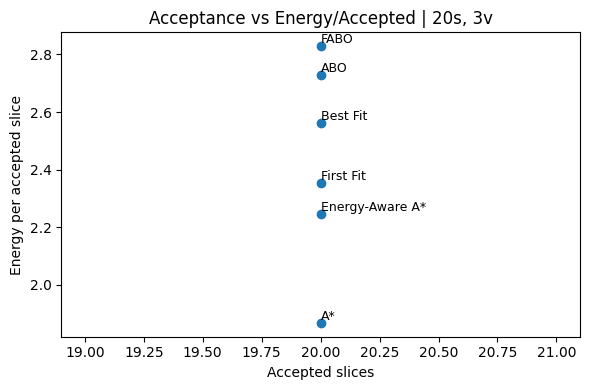

In [34]:
# --- Scatter: accepted vs energy per accepted, to reveal dominated methods ---
def scatter_acceptance_vs_energy(df, slices_target, vnfs_target, aggregate_over_seeds=True):
    d = df[(df["num_slices"]==slices_target) & (df["num_vnfs_per_slice"]==vnfs_target)].copy()
    d = _aggregate_scenario(d, aggregate_over_seeds=aggregate_over_seeds)

    plt.figure(figsize=(6,4))
    plt.scatter(d["accepted"], d["energy_per_accepted"])
    for _, r in d.iterrows():
        plt.text(r["accepted"], r["energy_per_accepted"], r["method"], fontsize=9, ha='left', va='bottom')
    plt.xlabel("Accepted slices")
    plt.ylabel("Energy per accepted slice")
    plt.title(f"Acceptance vs Energy/Accepted | {slices_target}s, {vnfs_target}v")
    plt.tight_layout()
    plt.show()

scatter_acceptance_vs_energy(df, slices_target=20, vnfs_target=3, aggregate_over_seeds=True)


In [35]:
# --- Imports and data loading (adjust the csv_path) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = "results/2025-11-07_11-19-24/load_scalability_results.csv"  # ajuste o caminho
df = pd.read_csv(csv_path)

# Quick sanity check
df.head()


,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec
0,2025-11-07 11:23:00,4,2,1,A*,4,8.4450,160.0,4.0,0.013677
1,2025-11-07 11:23:00,4,2,1,ABO,4,3.9100,160.0,8.0,1.694847
2,2025-11-07 11:23:00,4,2,1,FABO,4,10.1775,160.0,8.0,1.727064
3,2025-11-07 11:23:00,4,2,1,Best Fit,4,8.3000,320.0,16.0,0.001175
4,2025-11-07 11:23:00,4,2,1,First Fit,4,4.2850,160.0,12.0,0.000913


In [36]:
# --- Basic cleaning and derived columns ---
# Ensure expected columns exist
expected_cols = {
    "timestamp", "num_slices", "num_vnfs_per_slice", "seed",
    "method", "accepted", "total_energy", "total_bandwidth", "total_latency", "runtime_sec"
}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Convert numeric columns just in case
num_cols = ["num_slices", "num_vnfs_per_slice", "seed", "accepted",
            "total_energy", "total_bandwidth", "total_latency", "runtime_sec"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Derived KPIs
df["energy_per_accepted"] = np.where(df["accepted"] > 0, df["total_energy"] / df["accepted"], np.nan)
df["latency_per_accepted"] = np.where(df["accepted"] > 0, df["total_latency"] / df["accepted"], np.nan)


In [37]:
# --- Function to compute percentage comparisons for a given scenario ---
def compare_percentages(df, slices_target, vnfs_target, aggregate_over_seeds=True, baseline="A*"):
    """
    Computes percentage gains (higher is better) for energy, latency, and runtime.
    - Gains are computed as reduction vs 'worst' (max) among methods for the scenario.
    - Also computes reduction vs 'baseline' (e.g., "A*") if present.
    - If aggregate_over_seeds=True, first aggregates per method by mean over seeds.
    Returns a summary DataFrame.
    """
    # Filter scenario
    d = df[(df["num_slices"] == slices_target) & (df["num_vnfs_per_slice"] == vnfs_target)].copy()
    if d.empty:
        raise ValueError("No rows found for the requested scenario.")

    # Aggregate over seeds if requested
    if aggregate_over_seeds:
        agg = (d.groupby("method", as_index=False)
                 .agg(total_energy=("total_energy", "mean"),
                      total_latency=("total_latency", "mean"),
                      runtime_sec=("runtime_sec", "mean"),
                      accepted=("accepted", "mean"),
                      energy_per_accepted=("energy_per_accepted", "mean"),
                      latency_per_accepted=("latency_per_accepted", "mean")))
    else:
        # Keep as-is (e.g., if you want per-seed lines). For clean comparison, still group by method.
        agg = (d.groupby(["method", "seed"], as_index=False)
                 .agg(total_energy=("total_energy", "mean"),
                      total_latency=("total_latency", "mean"),
                      runtime_sec=("runtime_sec", "mean"),
                      accepted=("accepted", "mean"),
                      energy_per_accepted=("energy_per_accepted", "mean"),
                      latency_per_accepted=("latency_per_accepted", "mean")))
    
    # For percentage gains, we want one row per method; if seed is present, pick mean again
    if "seed" in agg.columns:
        agg = (agg.groupby("method", as_index=False)
                 .mean(numeric_only=True))

    # Compute worst values (max -> since we measure reductions)
    worst_energy = agg["total_energy"].max()
    worst_latency = agg["total_latency"].max()
    worst_runtime = agg["runtime_sec"].max()

    # Gains vs worst (%): (worst - value) / worst * 100
    agg["gain_energy_vs_worst_%"] = (worst_energy - agg["total_energy"]) / worst_energy * 100.0
    agg["gain_latency_vs_worst_%"] = (worst_latency - agg["total_latency"]) / worst_latency * 100.0
    agg["gain_runtime_vs_worst_%"] = (worst_runtime - agg["runtime_sec"]) / worst_runtime * 100.0

    # Gains vs baseline (%): (baseline - value) / baseline * 100
    if baseline in agg["method"].values:
        b = agg.loc[agg["method"] == baseline].iloc[0]
        agg["gain_energy_vs_baseline_%"] = (b["total_energy"] - agg["total_energy"]) / b["total_energy"] * 100.0
        agg["gain_latency_vs_baseline_%"] = (b["total_latency"] - agg["total_latency"]) / b["total_latency"] * 100.0
        agg["gain_runtime_vs_baseline_%"] = (b["runtime_sec"] - agg["runtime_sec"]) / b["runtime_sec"] * 100.0
    else:
        agg["gain_energy_vs_baseline_%"] = np.nan
        agg["gain_latency_vs_baseline_%"] = np.nan
        agg["gain_runtime_vs_baseline_%"] = np.nan

    # Order by best energy gain vs worst (descending)
    agg = agg.sort_values(by="gain_energy_vs_worst_%", ascending=False).reset_index(drop=True)

    # Keep a compact set of columns
    keep = [
        "method", "accepted",
        "total_energy", "total_latency", "runtime_sec",
        "energy_per_accepted", "latency_per_accepted",
        "gain_energy_vs_worst_%", "gain_latency_vs_worst_%", "gain_runtime_vs_worst_%",
        "gain_energy_vs_baseline_%", "gain_latency_vs_baseline_%", "gain_runtime_vs_baseline_%"
    ]
    return agg[keep]


In [38]:
# --- Run a scenario comparison and export as CSV ---
slices_target = 20
vnfs_target = 3

summary = compare_percentages(df, slices_target, vnfs_target, aggregate_over_seeds=True, baseline="A*")
display(summary)

out_csv = f"summary_percentages_{slices_target}slices_{vnfs_target}vnfs.csv"
summary.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


,method,accepted,total_energy,total_latency,runtime_sec,energy_per_accepted,latency_per_accepted,gain_energy_vs_worst_%,gain_latency_vs_worst_%,gain_runtime_vs_worst_%,gain_energy_vs_baseline_%,gain_latency_vs_baseline_%,gain_runtime_vs_baseline_%
0,A*,20.0,37.36375,52.0,0.281339,1.868188,2.60,33.951299,50.943396,98.546426,0.000000,0.000000,0.000000
1,Energy-Aware A*,20.0,44.68875,70.0,1.004080,2.234438,3.50,21.002740,33.962264,94.812289,-19.604563,-34.615385,-256.893527
2,First Fit,20.0,47.06750,97.0,0.007864,2.353375,4.85,16.797773,8.490566,99.959372,-25.971028,-86.538462,97.204963
3,Best Fit,20.0,51.24000,106.0,0.007498,2.562000,5.30,9.421955,0.000000,99.961263,-37.138269,-103.846154,97.335045
4,ABO,20.0,54.57000,95.0,19.354964,2.728500,4.75,3.535443,10.377358,0.000000,-46.050651,-82.692308,-6779.595600
5,FABO,20.0,56.57000,92.0,19.110733,2.828500,4.60,0.000000,13.207547,1.261852,-51.403432,-76.923077,-6692.785292


Saved: summary_percentages_20slices_3vnfs.csv


In [39]:
# --- Fair comparison utilities: acceptance-aware percentage analysis ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def aggregate_scenario(df, slices_target, vnfs_target, aggregate_over_seeds=True):
    """
    Aggregate rows for a fixed (num_slices, num_vnfs_per_slice) scenario.
    """
    d = df[(df["num_slices"] == slices_target) & (df["num_vnfs_per_slice"] == vnfs_target)].copy()
    if d.empty:
        raise ValueError("No rows for the requested scenario.")
        
    if aggregate_over_seeds:
        agg = (d.groupby("method", as_index=False)
                 .agg(total_energy=("total_energy", "mean"),
                      total_latency=("total_latency", "mean"),
                      runtime_sec=("runtime_sec", "mean"),
                      accepted=("accepted", "mean"),
                      total_bandwidth=("total_bandwidth","mean")))
    else:
        agg = d.copy()
    # Derive energy/latency per accepted
    agg["energy_per_accepted"]  = np.where(agg["accepted"]>0, agg["total_energy"]/agg["accepted"], np.nan)
    agg["latency_per_accepted"] = np.where(agg["accepted"]>0, agg["total_latency"]/agg["accepted"], np.nan)
    return agg


def fair_percentages(df, slices_target, vnfs_target, aggregate_over_seeds=True, baseline="A*"):
    """
    Acceptance-aware comparison in percentages.
    We provide TWO consistent views:

    View A (Strict): compare ONLY methods that achieved max acceptance in this scenario.
    View B (Normalized): for all methods, scale energy to hypothetical same acceptance (max_accepted),
                         assuming linear scaling w.r.t. accepted (conservative penalization).

    Returns:
      strict_cmp: methods with accepted == max_accepted (true apples-to-apples)
      norm_cmp: all methods with energy normalized to max_accepted
    """
    agg = aggregate_scenario(df, slices_target, vnfs_target, aggregate_over_seeds)
    # Round accepted if aggregated-over-seeds yields float very near an int
    agg["accepted_round"] = agg["accepted"].round(6)
    max_acc = agg["accepted_round"].max()

    # ------------- View A: Strict (only max acceptance) -------------
    strict = agg[agg["accepted_round"] == max_acc].copy()
    if not strict.empty:
        # Gains vs worst among strict set
        worst_E = strict["total_energy"].max()
        worst_L = strict["total_latency"].max()
        worst_T = strict["runtime_sec"].max()

        strict["gain_energy_vs_worst_%"]  = (worst_E - strict["total_energy"]) / worst_E * 100.0
        strict["gain_latency_vs_worst_%"] = (worst_L - strict["total_latency"]) / worst_L * 100.0
        strict["gain_runtime_vs_worst_%"] = (worst_T - strict["runtime_sec"]) / worst_T * 100.0

        # Optional: gains vs baseline if baseline is in strict set
        if baseline in strict["method"].values:
            b = strict.loc[strict["method"] == baseline].iloc[0]
            strict["gain_energy_vs_baseline_%"]  = (b["total_energy"]  - strict["total_energy"])  / b["total_energy"]  * 100.0
            strict["gain_latency_vs_baseline_%"] = (b["total_latency"] - strict["total_latency"]) / b["total_latency"] * 100.0
            strict["gain_runtime_vs_baseline_%"] = (b["runtime_sec"]   - strict["runtime_sec"])   / b["runtime_sec"]   * 100.0
        else:
            strict["gain_energy_vs_baseline_%"] = np.nan
            strict["gain_latency_vs_baseline_%"] = np.nan
            strict["gain_runtime_vs_baseline_%"] = np.nan

    # ------------- View B: Normalized to same acceptance -------------
    norm = agg.copy()
    # Linear normalization (conservative): energy at equal acceptance
    # If a method accepted less, we scale up its energy to match max_accepted.
    # If accepted == 0, set to +inf to strongly penalize.
    norm["energy_norm_to_max_accept"] = np.where(
        norm["accepted_round"] > 0,
        norm["total_energy"] * (max_acc / norm["accepted_round"]),
        np.inf
    )
    # Gains vs worst using normalized energy
    worst_E_norm = norm["energy_norm_to_max_accept"].replace([np.inf, -np.inf], np.nan).max()
    norm["gain_energy_norm_vs_worst_%"] = (worst_E_norm - norm["energy_norm_to_max_accept"]) / worst_E_norm * 100.0

    # Keep acceptance context
    norm["acceptance_ratio_%"] = (norm["accepted_round"] / max_acc) * 100.0
    norm["acceptance_gap"] = max_acc - norm["accepted_round"]

    # Order for readability
    strict = strict.sort_values(by="gain_energy_vs_worst_%", ascending=False) if not strict.empty else strict
    norm   = norm.sort_values(by="gain_energy_norm_vs_worst_%", ascending=False)

    return strict.reset_index(drop=True), norm.reset_index(drop=True), int(max_acc)


def plot_bars_percent(summary, col_percent, title):
    """Simple bar plot for percentage columns (one plot per metric)."""
    x = np.arange(len(summary))
    y = summary[col_percent].values
    labels = summary["method"].values

    plt.figure(figsize=(8, 4))
    plt.bar(x, y)
    plt.xticks(x, labels, rotation=20, ha="right")
    plt.ylabel("%")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [40]:
# --- Run fair analysis for a scenario ---
slices_target = 20
vnfs_target   = 3

strict_cmp, norm_cmp, max_acc = fair_percentages(
    df, slices_target, vnfs_target,
    aggregate_over_seeds=True, baseline="A*"
)

print(f"[Scenario] {slices_target} slices, {vnfs_target} VNFs/slice | Max accepted = {max_acc}")
print("\n=== View A: STRICT (only methods with max acceptance) ===")
display(strict_cmp[[
    "method", "accepted", "total_energy", "total_latency", "runtime_sec",
    "gain_energy_vs_worst_%", "gain_latency_vs_worst_%", "gain_runtime_vs_worst_%",
    "gain_energy_vs_baseline_%", "gain_latency_vs_baseline_%", "gain_runtime_vs_baseline_%"
]])

print("\n=== View B: NORMALIZED (all methods, energy scaled to same acceptance) ===")
display(norm_cmp[[
    "method", "accepted", "acceptance_ratio_%", "energy_per_accepted", "energy_norm_to_max_accept",
    "gain_energy_norm_vs_worst_%", "total_latency", "runtime_sec"
]])


[Scenario] 20 slices, 3 VNFs/slice | Max accepted = 20

=== View A: STRICT (only methods with max acceptance) ===


,method,accepted,total_energy,total_latency,runtime_sec,gain_energy_vs_worst_%,gain_latency_vs_worst_%,gain_runtime_vs_worst_%,gain_energy_vs_baseline_%,gain_latency_vs_baseline_%,gain_runtime_vs_baseline_%
0,A*,20.0,37.36375,52.0,0.281339,33.951299,50.943396,98.546426,0.000000,0.000000,0.000000
1,Energy-Aware A*,20.0,44.68875,70.0,1.004080,21.002740,33.962264,94.812289,-19.604563,-34.615385,-256.893527
2,First Fit,20.0,47.06750,97.0,0.007864,16.797773,8.490566,99.959372,-25.971028,-86.538462,97.204963
3,Best Fit,20.0,51.24000,106.0,0.007498,9.421955,0.000000,99.961263,-37.138269,-103.846154,97.335045
4,ABO,20.0,54.57000,95.0,19.354964,3.535443,10.377358,0.000000,-46.050651,-82.692308,-6779.595600
5,FABO,20.0,56.57000,92.0,19.110733,0.000000,13.207547,1.261852,-51.403432,-76.923077,-6692.785292



=== View B: NORMALIZED (all methods, energy scaled to same acceptance) ===


,method,accepted,acceptance_ratio_%,energy_per_accepted,energy_norm_to_max_accept,gain_energy_norm_vs_worst_%,total_latency,runtime_sec
0,A*,20.0,100.0,1.868188,37.36375,33.951299,52.0,0.281339
1,Energy-Aware A*,20.0,100.0,2.234438,44.68875,21.002740,70.0,1.004080
2,First Fit,20.0,100.0,2.353375,47.06750,16.797773,97.0,0.007864
3,Best Fit,20.0,100.0,2.562000,51.24000,9.421955,106.0,0.007498
4,ABO,20.0,100.0,2.728500,54.57000,3.535443,95.0,19.354964
5,FABO,20.0,100.0,2.828500,56.57000,0.000000,92.0,19.110733


In [41]:
from milp.create_instance import create_instance
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

MILP_TIME_LIMIT = 300       # Time limit per MILP run (seconds)
ENTRY = 6                   # Fixed entry node
MAX_MILP_SLICES = 30        # Run MILP only if number of slices ≤ this
MAX_MILP_VNFS_TOTAL = 120    # Hard cap: total VNFs (num_slices × num_vnfs) ≤ this


param_grid = {
    "num_slices": [4,6, 8, 10 ,12, 18, 20],
    "num_vnfs_per_slice": [2, 3],
    "seed": [1],
}


for num_slices in param_grid["num_slices"]:
    for num_vnfs in param_grid["num_vnfs_per_slice"]:
        total_vnfs = num_slices * num_vnfs
        for seed in param_grid["seed"]:
            random.seed(seed)
            np.random.seed(seed)

            print(f"\n[INFO] === Running Load Test: {num_slices} slices × {num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

            # --- Generate random slices ---
            slices = generate_random_slices(
                G,
                vnf_profiles,
                num_slices=num_slices,
                num_vnfs_per_slice=num_vnfs,
                entry=ENTRY
            )

            method_results = {}
            method_times = {}

            # --- Heuristics ---
            for name, func, args in [
                ("A*", run_astar, (G, slices, node_capacity_base, link_capacity_base)),
                ("ABO", run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("FABO", run_fabo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
                ("Best Fit", run_best_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("First Fit", run_first_fit, (G, slices, node_capacity_base, link_capacity_base, link_latency)),
                ("Energy-Aware A*", energy_aware_astar,
 (G, slices, node_capacity_base, link_capacity_base,
  0.6, 0.4,))

            ]:
                start = time.time()
                try:
                    df_res, res_list = func(*args)
                    method_results[name] = res_list
                except Exception as e:
                    print(f"[ERROR] {name} failed: {e}")
                    method_results[name] = []
                method_times[name] = time.time() - start

            # --- MILP (only for small scenarios) ---
            if num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
                try:
                    print(f"\n[INFO][MILP] Running Gurobi MILP for {num_slices} slices ({total_vnfs} VNFs, limit {MILP_TIME_LIMIT}s)...")
                    start = time.time()

                    instance = create_instance(G, slices)
                    instance.entry_node = ENTRY

                    res = solve_gurobi(instance, msg=False, time_limit=MILP_TIME_LIMIT)
                    milp_adapter = MILPResultAdapterGurobi(res, instance)

                    method_results["MILP (Gurobi)"] = [milp_adapter]
                    method_times["MILP (Gurobi)"] = time.time() - start

                    print(f"[INFO][MILP] Completed in {method_times['MILP (Gurobi)']:.1f}s (status={res.status_str})")

                except Exception as e:
                    print(f"[ERROR][MILP] Failed: {e}")
                    method_results["MILP (Gurobi)"] = []
                    method_times["MILP (Gurobi)"] = None

            else:
                print(f"[SKIP][MILP] Skipped: {num_slices} slices × {num_vnfs} VNFs "
                      f"(total={total_vnfs}) exceeds limit ({MAX_MILP_SLICES} slices or {MAX_MILP_VNFS_TOTAL} VNFs).")

            # --- Compute metrics ---
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })

# --- Save results ---
df_results = pd.DataFrame(records)
output_path = os.path.join(results_dir, "scalability_results.csv")
df_results.to_csv(output_path, index=False)
print(f"\n[INFO] Results saved to {output_path}")



[INFO] === Running Load Test: 4 slices × 2 VNFs (total=8), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][ABO] === Solving slice 1 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 1 accepted. min_node_cpu=14, links_low_bw=0

[INFO][ABO] === Solving slice 2 (2 VNFs, 1 VLs) ===
[INFO][ABO] Found feasible solution after 10 states.
[SUMMARY][ABO] Slice 2 accepted. min_node_cpu=12, links_low_bw=0

[INFO][ABO] === Solving slice 3 (2 VNFs, 1 VLs) ===
[INFO][ABO

In [38]:
df_results

,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,total_vnfs
0,2025-11-12 08:24:10,4,2,1,A*,4,8.4450,160.0,4.0,0.013927,NaN
1,2025-11-12 08:24:10,4,2,1,ABO,4,3.9100,160.0,8.0,1.849478,NaN
2,2025-11-12 08:24:10,4,2,1,FABO,4,10.1775,160.0,8.0,1.859253,NaN
3,2025-11-12 08:24:10,4,2,1,Best Fit,4,8.3000,320.0,16.0,0.001091,NaN
4,2025-11-12 08:24:10,4,2,1,First Fit,4,4.2850,160.0,12.0,0.000979,NaN
...,...,...,...,...,...,...,...,...,...,...,...
177,2025-11-12 08:33:20,20,3,1,FABO,20,56.5700,2600.0,92.0,18.531980,60.0
178,2025-11-12 08:33:20,20,3,1,Best Fit,20,51.2400,3160.0,106.0,0.008259,60.0
179,2025-11-12 08:33:20,20,3,1,First Fit,20,47.0675,3270.0,97.0,0.007744,60.0
180,2025-11-12 08:33:20,20,3,1,Energy-Aware A*,20,44.8900,2320.0,58.0,0.935291,60.0


In [39]:
import pandas as pd

df = pd.read_csv("./results/2025-10-21_14-46-46/scalability_results.csv")
print(df.shape)
print(df.columns)
df


(182, 11)
Index(['timestamp', 'num_slices', 'num_vnfs_per_slice', 'seed', 'method',
       'accepted', 'total_energy', 'total_bandwidth', 'total_latency',
       'runtime_sec', 'total_vnfs'],
      dtype='object')


,timestamp,num_slices,num_vnfs_per_slice,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,total_vnfs
0,2025-10-21 14:50:16,4,2,1,A*,4,3.203013,160.0,20.0,0.039638,NaN
1,2025-10-21 14:50:16,4,2,1,ABO,4,3.261455,160.0,40.0,0.283258,NaN
2,2025-10-21 14:50:16,4,2,1,FABO,0,3.224026,0.0,20.0,0.179127,NaN
3,2025-10-21 14:50:16,4,2,1,Best Fit,4,13.164000,800.0,150.0,0.001385,NaN
4,2025-10-21 14:50:16,4,2,1,First Fit,4,10.400727,1280.0,300.0,0.001386,NaN
...,...,...,...,...,...,...,...,...,...,...,...
177,2025-10-21 14:53:41,20,3,1,FABO,2,15.142823,900.0,210.0,2.745785,60.0
178,2025-10-21 14:53:41,20,3,1,Best Fit,4,29.766000,2340.0,350.0,0.045048,60.0
179,2025-10-21 14:53:41,20,3,1,First Fit,20,22.784545,13300.0,2190.0,0.010264,60.0
180,2025-10-21 14:53:41,20,3,1,Energy-Aware A*,20,13.937292,2850.0,305.0,7.116419,60.0


In [40]:
print(df.columns.tolist())


['timestamp', 'num_slices', 'num_vnfs_per_slice', 'seed', 'method', 'accepted', 'total_energy', 'total_bandwidth', 'total_latency', 'runtime_sec', 'total_vnfs']


In [44]:
df = df.copy()
df = df[df["accepted"] > 0]  # evita divisão por zero
df["energy_per_accepted"] = df["total_energy"] / df["accepted"]


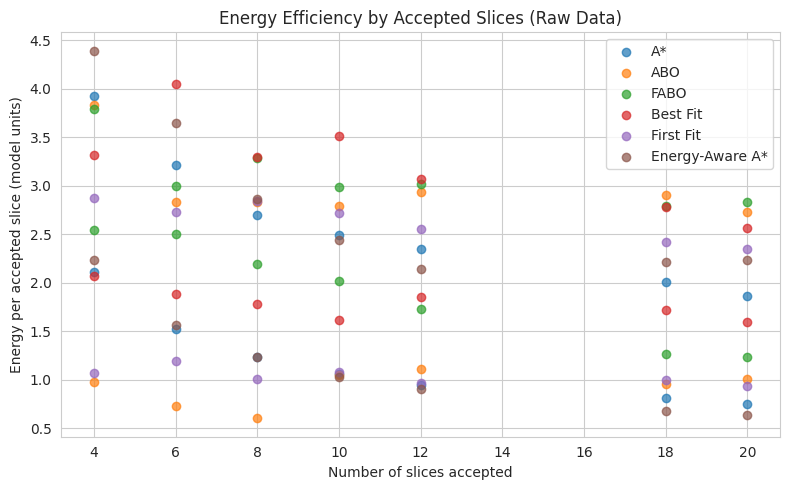

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for m in df["method"].unique():
    subset = df[df["method"] == m]
    plt.scatter(
        subset["accepted"], subset["energy_per_accepted"],
        alpha=0.7, label=m
    )

plt.xlabel("Number of slices accepted")
plt.ylabel("Energy per accepted slice (model units)")
plt.title("Energy Efficiency by Accepted Slices (Raw Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
import statsmodels.api as sm
print("Statsmodels version:", sm.__version__)


Statsmodels version: 0.14.5


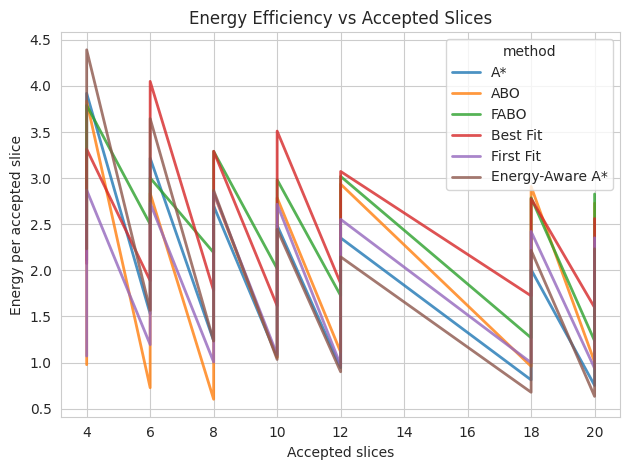

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Gráfico suavizado sem statsmodels
sns.lineplot(
    data=df.sort_values("accepted"),
    x="accepted",
    y="energy_per_accepted",
    hue="method",
    estimator=None,   # usa os dados brutos
    lw=2,
    alpha=0.8
)
plt.xlabel("Accepted slices")
plt.ylabel("Energy per accepted slice")
plt.title("Energy Efficiency vs Accepted Slices")
plt.tight_layout()
plt.show()


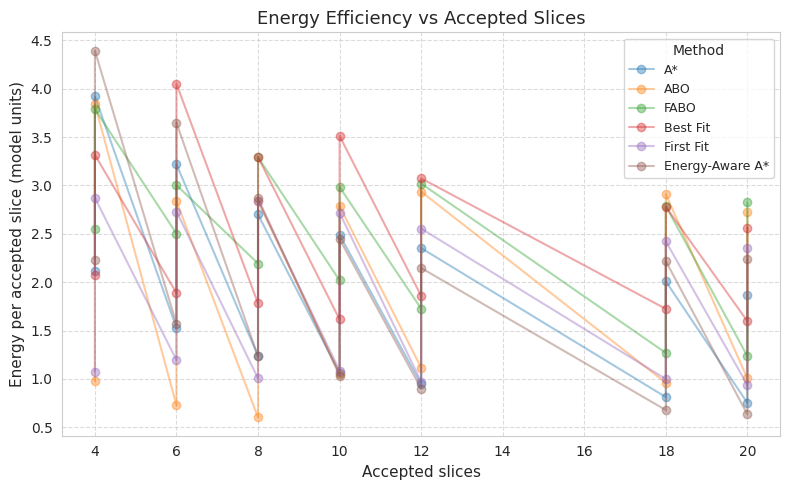

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações visuais
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

highlight = "MILP (Gurobi)"  # método que será destacado

# Paleta de cores consistente
palette = sns.color_palette("tab10", n_colors=len(df["method"].unique()))

for m, color in zip(df["method"].unique(), palette):
    subset = df[df["method"] == m]
    lw = 3.5 if m == highlight else 1.5     # destaque no MILP
    alpha = 1.0 if m == highlight else 0.4  # suaviza os outros
    zorder = 3 if m == highlight else 2
    plt.plot(
        subset["accepted"], subset["energy_per_accepted"],
        label=m, lw=lw, alpha=alpha, color=color, marker="o", zorder=zorder
    )

# Eixos e títulos
plt.xlabel("Accepted slices", fontsize=11)
plt.ylabel("Energy per accepted slice (model units)", fontsize=11)
plt.title("Energy Efficiency vs Accepted Slices", fontsize=13)
plt.legend(title="Method", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Exportar em alta resolução (opcional)
# plt.savefig("energy_efficiency_vs_accepted_slices.png", dpi=300, bbox_inches="tight")

plt.show()


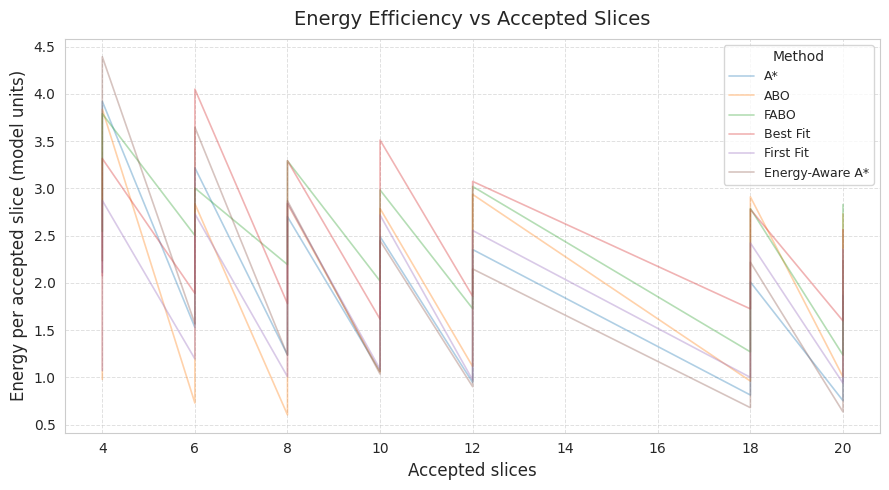

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(9,5))

highlight = "MILP (Gurobi)"  # método destacado

# Paleta consistente
palette = sns.color_palette("tab10", n_colors=len(df["method"].unique()))

for m, color in zip(df["method"].unique(), palette):
    subset = df[df["method"] == m].sort_values("accepted")
    lw = 3.5 if m == highlight else 1.2
    alpha = 1.0 if m == highlight else 0.35
    zorder = 3 if m == highlight else 2
    marker = "o" if m == highlight else None
    plt.plot(
        subset["accepted"], subset["energy_per_accepted"],
        label=m, lw=lw, alpha=alpha, color=color, marker=marker, zorder=zorder
    )

# --- Ajustes visuais ---
plt.xlabel("Accepted slices", fontsize=12)
plt.ylabel("Energy per accepted slice (model units)", fontsize=12)
plt.title("Energy Efficiency vs Accepted Slices", fontsize=14, pad=10)

# Destaque leve no eixo Y
plt.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
plt.legend(title="Method", fontsize=9, loc="upper right")
plt.tight_layout()

# Salvar em alta resolução (opcional)
# plt.savefig("energy_efficiency_vs_accepted_slices_highlighted.png", dpi=300, bbox_inches="tight")

plt.show()


In [51]:
summary = (
    df.groupby("method")[["accepted", "total_energy", "total_latency", "runtime_sec"]]
      .mean()
      .sort_values("total_energy")
)
print(summary)


                  accepted  total_energy  total_latency  runtime_sec
method                                                              
A*               11.142857     18.737500      19.214286     0.107837
Energy-Aware A*  11.142857     19.388929      32.642857     0.359477
First Fit        11.142857     19.844464      45.928571     0.003339
ABO              11.142857     21.391875      32.500000     9.233523
FABO             11.142857     25.962500      32.285714     8.893097
Best Fit         11.142857     26.601786      45.071429     0.003280


In [53]:
comp = (
    df
    .groupby(["num_slices", "method"])
    .agg(
        avg_energy=("total_energy", "mean"),
        avg_latency=("total_latency", "mean"),
        avg_accept=("accepted", "mean"),
        avg_runtime=("runtime_sec", "mean")
    )
    .reset_index()
)

print(comp)


    num_slices           method  avg_energy  avg_latency  avg_accept  \
0            4               A*   12.063750          6.0         4.0   
1            4              ABO    9.627500         10.0         4.0   
2            4         Best Fit   10.780000         17.0         4.0   
3            4  Energy-Aware A*   13.252500         11.5         4.0   
4            4             FABO   12.667500         10.0         4.0   
5            4        First Fit    7.885000         15.0         4.0   
6            6               A*   14.236250          9.0         6.0   
7            6              ABO   10.691250         15.0         6.0   
8            6         Best Fit   17.815000         24.0         6.0   
9            6  Energy-Aware A*   15.641250         17.5         6.0   
10           6             FABO   16.512500         15.0         6.0   
11           6        First Fit   11.772500         23.0         6.0   
12           8               A*   15.743125         12.0        

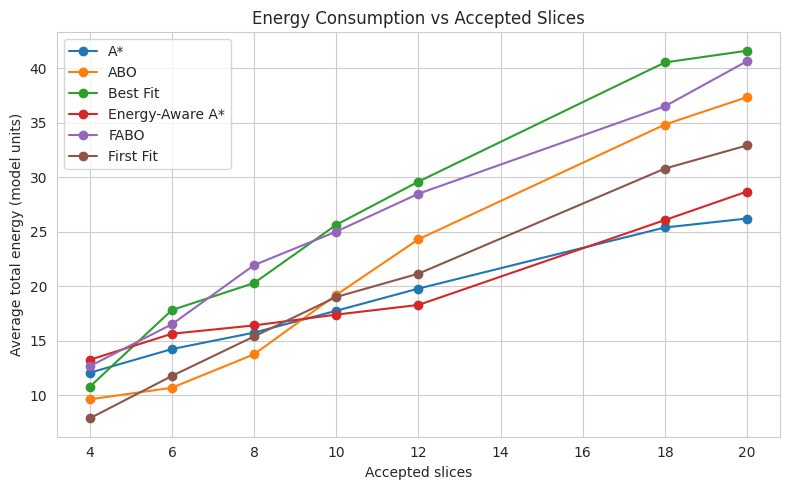

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for m in comp["method"].unique():
    subset = comp[comp["method"] == m]
    plt.plot(
        subset["avg_accept"], subset["avg_energy"],   # eixo x agora = avg_accept
        marker="o", label=m
    )

plt.xlabel("Accepted slices")
plt.ylabel("Average total energy (model units)")
plt.title("Energy Consumption vs Accepted Slices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
print(comp.columns.tolist())


['num_slices', 'method', 'avg_energy', 'avg_latency', 'avg_accept', 'avg_runtime']
